 - __Import base modules__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

 - __Import sklearn modules__

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


 - __Import TfidfVectorizer__

In [5]:
from gensim.models import KeyedVectors

 - __Import the spam/ham dataset__

In [6]:
url="https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/spam_ham_text_classification.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0)
dataset.head(4)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


 - __Check if missing values exist__

In [7]:
dataset.isnull().sum()

Category    0
Message     0
dtype: int64

 - __Check proportion of class values__
 - __Yes, fair imbalance exists__

In [8]:
dataset.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

 - __Check if NaN values are there and if yes then collect row indices__

In [9]:
blanks = []
for index, label, review in dataset.itertuples():
    if type(review)==str:
        if review.isspace():
            blanks.append(index)
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


 - __Download google word2vec pre trained model from gensim__

In [12]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


 - __Create unique set of words from google model__

In [13]:
vocabulary = set(wv.index2word)

 - __Dimension of each word__

In [14]:
embedding_size = wv.vector_size

In [15]:
print("Model contains %d words" %len(vocabulary))

Model contains 3000000 words


In [16]:
print("Each word is represented by a %d dimensional vector" %embedding_size)

Each word is represented by a 300 dimensional vector


 - __Create X and y attrs__

In [17]:
X, y = dataset['Message'], dataset['Category']
sdict = {'spam': 1, 'ham': 0}
y = y.map(sdict)
X.shape, y.shape

((5572,), (5572,))

In [19]:
print('Number of messages = %d.' %len(X))
print('Number of labels = %d.' %len(y))

Number of messages = 5572.
Number of labels = 5572.


In [20]:
print("Number of missing messages: %d." %(np.sum(pd.isnull(X))))
print("Number of distinct messages = %d" %(dataset.Message.nunique()))

Number of missing messages: 0.
Number of distinct messages = 5157


 - __Define word2vec function where mean of the vectors would be considered if the word exists__
 - __Else zero__

In [24]:
def mean_vector(review):
    zero = np.zeros((embedding_size,), dtype="float32")
    if pd.isnull(review):
        return zero
    words = [w for w in review.split() if w in vocabulary]
    if not words:
        return zero
    return np.mean([wv[w] for w in words], axis=0)

In [22]:
cols = ['v_'+str(i) for i in range(embedding_size)]

In [25]:
dfV = pd.DataFrame(list(map(mean_vector, X)), columns=cols)

In [26]:
dfV.insert(0, 'target', dataset['Category'])

In [27]:
print('Representation has %d rows and %d columns' %dfV.shape)

Representation has 5572 rows and 301 columns


In [33]:
X = dfV.drop(labels='target', axis=1)
y = dfV.target
y = y.map(sdict)
X.shape, y.shape

((5572, 300), (5572,))

 - __Create training and testing datasets__

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3900, 300), (1672, 300), (3900,), (1672,))

In [35]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 523
Before OverSampling, counts of label '0': 3377 



 - __Apply SMOTE to uplift class imbalance only in training data__

In [36]:
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [37]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
X_train_res.shape, X_test.shape, y_train_res.shape, y_test.shape

After OverSampling, counts of label '1': 3377
After OverSampling, counts of label '0': 3377


((6754, 300), (1672, 300), (6754,), (1672,))

 - __Import Light GBM module__

In [38]:
import lightgbm as lgb

 - __Declare estimator__

In [39]:
estimator = lgb.LGBMClassifier(boosting_type ="goss", random_state=1)

 - __Declare a decimal range of learning rates__
 - __Declare a range of tree counts__
 - __Declare a set of max depth values__
 - __Declare a set of minimum child weight__
 - __Declare a set of sample proportions to be used in attribute sampling__
 - __Create dictionary which is a must for Random Search function__

In [40]:
learning_rate = np.arange(0.01,1,0.05)
n_estimators = np.arange(100, 500, 50)
max_depth = [2, 5, 10, 20, 30, 40, 50]
min_child_weight = [1,3,6]
colsample_bytree = [0.1, 0.5, 0.8, 1]
num_leaves = [300, 900, 1200]

param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'colsample_bytree': colsample_bytree,
              'num_leaves': num_leaves}

 - __Instantiate the RandomizedSearchCV object with accuracy as scoring metric__
 - __Push the parameter dictionary inside the object__

In [41]:
randomized_accuracy_fit = RandomizedSearchCV(estimator=estimator,
                                            param_distributions=param_grid,
                                            n_iter=50,
                                            scoring="accuracy",
                                            n_jobs=-1,
                                            refit=True,
                                            random_state=123,
                                            return_train_score=True,
                                            verbose=1,
                                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
                                            )

 - __Fit the RandomizedSearchCV object on X_train & y_train__

In [42]:
training_start = time.perf_counter()
randomized_accuracy_fit.fit(X_train_res, y_train_res)
training_end = time.perf_counter()
lgb_train_time = training_end-training_start
print("Time consumed for training: %4.3f seconds" % (lgb_train_time))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 21.4min finished


Time consumed for training: 1287.169 seconds


 - __Print the best score found by RandomizedSearchCV__
 - __Print the best model found by RandomizedSearchCV__

In [43]:
print(randomized_accuracy_fit.best_score_)
print(randomized_accuracy_fit.best_estimator_)

0.9927451238220468
LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=0.1,
               importance_type='split', learning_rate=0.11, max_depth=50,
               min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=1200, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


 - __Store the best model in an object__
 - __Create predictions from the best model__

In [44]:
best_estimator = randomized_accuracy_fit.best_estimator_
prediction_start = time.perf_counter()
y_pred = best_estimator.predict(X_test)
prediction_end = time.perf_counter()
lgb_prediction_time = prediction_end-prediction_start
print("Time consumed for prediction: %6.5f seconds" % (lgb_prediction_time))

Time consumed for prediction: 0.07650 seconds


 - __Calculate Accuracy and Recall Scores__
 - __Print the respective values__
 - __Create confusion matrix and print it using heatmap__

The accuracy score for the model is: 0.977
The recall score for the model is: 0.928
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1448
           1       0.96      0.86      0.91       224

    accuracy                           0.98      1672
   macro avg       0.97      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



Text(91.68, 0.5, 'Actual')

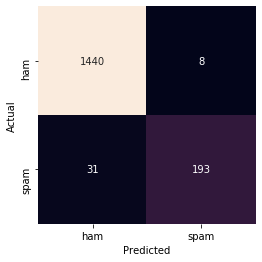

In [45]:
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred, average="macro"), 3)
cre = classification_report(y_test,y_pred)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print(cre)
met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False, xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")